<a href="https://colab.research.google.com/github/sagar9926/MTech_Atificial_Intelligence/blob/main/ML1/Fractal3_Assignment/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. Custom Model Architecture
3. Training Cifar 10
4. Train Cifar Using VGG16

In [9]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


import torch.nn.functional as F
import torch.optim as optim
import math
import albumentations as A
import copy

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [11]:
# Transforming train and test dataset

transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    transforms.RandomErasing(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

In [12]:
# Downloading the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
num_classes = 10

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
8


In [15]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 # denormalising the image
    plt.figure(figsize=(batch_size*20, 2))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [16]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images) # puts together images to form a bigger image
    imshow(img, title=[trainset.classes[x.item()] for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


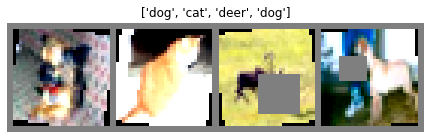

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


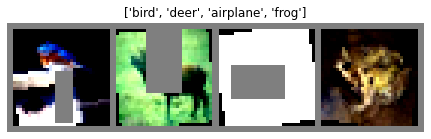

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


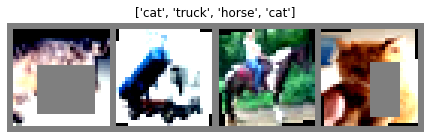

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


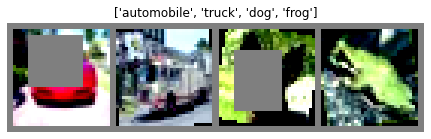

In [ ]:
for i in range(4):
    show_batch_images(trainloader)

# Custom Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 32 , 32]

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 30 , 30]

        # pooling layer
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = [N , 48 , 15 , 15]

        self.convblock3 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 15 , 15]

        self.convblock4 = nn.Sequential(
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 13 , 13]

        # pooling layer
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = [N , 96 , 6 , 6]

        self.convblock5 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU()
        ) # output_size = [N , 192 , 6 , 6]

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = [N , 192 , 4 , 4]

        self.fc_model = nn.Sequential(
            nn.Linear(3072*2,512),         # (N, 3072*2) -> (N, 512)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,512),             # (N, 512) -> (N, 512)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,256),          # (N, 512) -> (N, 256)
            nn.Linear(256,10)            # (N, 256)  -> (N, 10)
        )
      

    def forward(self, x):
        img = copy.deepcopy(x)
               
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)

        x = self.convblock5(x)
        x = self.convblock6(x)
        x = x.view(x.size(0), -1) # (N, 16, 5, 5) -> (N, 400)
        
        #Skip connection feeding input image directly into Fully connected layers
        x = torch.cat((x,img.reshape(x.size(0),-1)),dim = 1)
        
        x = self.fc_model(x)

        return F.log_softmax(x, dim=-1)


In [ ]:
from torchsummary import summary
net = Net().to(device)
print(summary(net, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              ReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 30, 30]          20,736
       BatchNorm2d-5           [-1, 48, 30, 30]              96
              ReLU-6           [-1, 48, 30, 30]               0
         MaxPool2d-7           [-1, 48, 15, 15]               0
           Dropout-8           [-1, 48, 15, 15]               0
            Conv2d-9           [-1, 96, 15, 15]          41,472
      BatchNorm2d-10           [-1, 96, 15, 15]             192
             ReLU-11           [-1, 96, 15, 15]               0
           Conv2d-12           [-1, 96, 13, 13]          82,944
      BatchNorm2d-13           [-1, 96, 13, 13]             192
             ReLU-14           [-1, 96,

# Train CIFAR10

In [ ]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total


In [ ]:
# Initialise and move model to Cuda
net = Net().to(device)

#this takes into consideration that we have to differentiate through softmax layer, given softmax is not applied in our vgg
loss_fn = nn.CrossEntropyLoss() 
opt = optim.SGD(net.parameters(), lr=0.01,momentum = 0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(trainloader)*10, gamma=0.01)


In [ ]:
# Training Loop

loss_epoch_arr_CNN_MLP = []
max_epochs = 150
train_acc_CNN_MLP = []
val_acc_CNN_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_CNN_MLP.append(loss.item())
    train_acc_CNN_MLP.append(evaluation(trainloader, net))
    val_acc_CNN_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 1.33
Epoch: 1/150, Test acc: 55.67, Train acc: 52.39
Iteration: 0/782, Loss: 1.39
Iteration: 500/782, Loss: 1.09
Epoch: 2/150, Test acc: 63.41, Train acc: 60.21
Iteration: 0/782, Loss: 0.93
Iteration: 500/782, Loss: 1.07
Epoch: 3/150, Test acc: 67.63, Train acc: 64.51
Iteration: 0/782, Loss: 1.01
Iteration: 500/782, Loss: 0.98
Epoch: 4/150, Test acc: 70.73, Train acc: 66.99
Iteration: 0/782, Loss: 0.69
Iteration: 500/782, Loss: 1.01
Epoch: 5/150, Test acc: 71.02, Train acc: 68.14
Iteration: 0/782, Loss: 0.79
Iteration: 500/782, Loss: 0.78
Epoch: 6/150, Test acc: 72.68, Train acc: 69.71
Iteration: 0/782, Loss: 0.99
Iteration: 500/782, Loss: 0.78
Epoch: 7/150, Test acc: 74.06, Train acc: 71.09
Iteration: 0/782, Loss: 1.02
Iteration: 500/782, Loss: 0.69
Epoch: 8/150, Test acc: 75.12, Train acc: 72.86
Iteration: 0/782, Loss: 0.73
Iteration: 500/782, Loss: 0.66
Epoch: 9/150, Test acc: 76.75, Train acc: 74.30
Iteration: 0/782, Loss: 0.69

## Training Last 10 epochs without Random Eraser

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
max_epochs = 10

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_CNN_MLP.append(loss.item())
    train_acc_CNN_MLP.append(evaluation(trainloader, net))
    val_acc_CNN_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))


Iteration: 0/782, Loss: 0.08
Iteration: 500/782, Loss: 0.02
Epoch: 1/10, Test acc: 84.69, Train acc: 97.58
Iteration: 0/782, Loss: 0.17
Iteration: 500/782, Loss: 0.10
Epoch: 2/10, Test acc: 84.88, Train acc: 97.48
Iteration: 0/782, Loss: 0.08
Iteration: 500/782, Loss: 0.10
Epoch: 3/10, Test acc: 84.81, Train acc: 97.40
Iteration: 0/782, Loss: 0.07
Iteration: 500/782, Loss: 0.09
Epoch: 4/10, Test acc: 84.39, Train acc: 97.49
Iteration: 0/782, Loss: 0.04
Iteration: 500/782, Loss: 0.13
Epoch: 5/10, Test acc: 85.02, Train acc: 97.80
Iteration: 0/782, Loss: 0.04
Iteration: 500/782, Loss: 0.05
Epoch: 6/10, Test acc: 84.74, Train acc: 97.62
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.00
Epoch: 7/10, Test acc: 85.05, Train acc: 97.77
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.06
Epoch: 8/10, Test acc: 84.99, Train acc: 97.80
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.05
Epoch: 9/10, Test acc: 85.12, Train acc: 97.69
Iteration: 0/782, Loss: 0.06
Iteratio

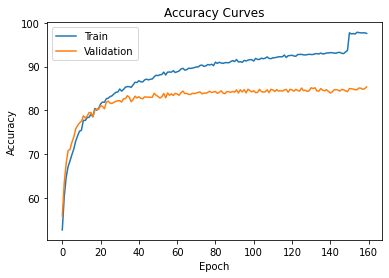

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_CNN_MLP,label='Train')
ax.plot(val_acc_CNN_MLP, label='Validation')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

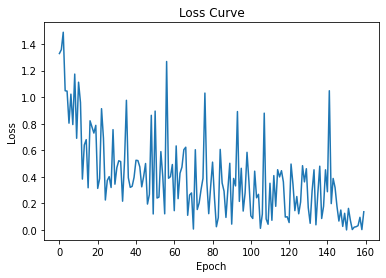

In [ ]:
plt.plot(loss_epoch_arr_CNN_MLP)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#Testing Model on a random image

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle=True)
for data in testloader:
  image , label = data
  break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


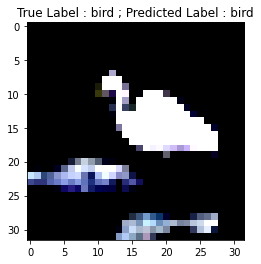

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


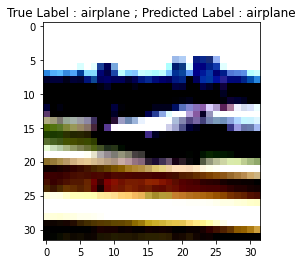

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


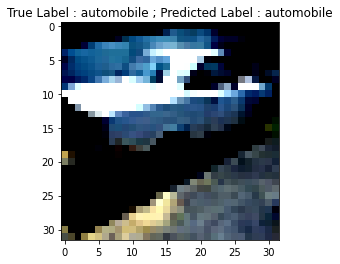

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


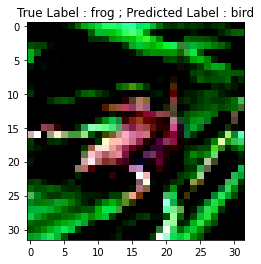

In [ ]:

for img , label in zip(image , label):
  _,prediction = torch.max(net(img.unsqueeze(0)).data,1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"True Label : {trainset.classes[label.item()]} ; Predicted Label : {trainset.classes[prediction]}")
  plt.show()

## Using MLP

In [186]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [187]:
pca = PCA()
pca_result = pca.fit(x_train)

In [188]:
pca.n_components_

3072

In [189]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [190]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [191]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [197]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [198]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [199]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [200]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [201]:
# Training Loop

loss_epoch_arr_MLP = []
max_epochs = 150
train_acc_MLP = []
val_acc_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_MLP.append(loss.item())
    train_acc_MLP.append(evaluation(trainloader, net))
    val_acc_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.30
Iteration: 500/782, Loss: 2.23
Epoch: 1/150, Test acc: 23.70, Train acc: 23.28
Iteration: 0/782, Loss: 2.17
Iteration: 500/782, Loss: 2.07
Epoch: 2/150, Test acc: 30.02, Train acc: 29.78
Iteration: 0/782, Loss: 2.05
Iteration: 500/782, Loss: 1.99
Epoch: 3/150, Test acc: 34.26, Train acc: 34.45
Iteration: 0/782, Loss: 1.90
Iteration: 500/782, Loss: 1.93
Epoch: 4/150, Test acc: 37.93, Train acc: 37.84
Iteration: 0/782, Loss: 1.77
Iteration: 500/782, Loss: 1.85
Epoch: 5/150, Test acc: 39.92, Train acc: 39.79
Iteration: 0/782, Loss: 1.68
Iteration: 500/782, Loss: 1.77
Epoch: 6/150, Test acc: 42.07, Train acc: 41.79
Iteration: 0/782, Loss: 1.60
Iteration: 500/782, Loss: 1.75
Epoch: 7/150, Test acc: 43.41, Train acc: 43.63
Iteration: 0/782, Loss: 1.61
Iteration: 500/782, Loss: 1.66
Epoch: 8/150, Test acc: 45.18, Train acc: 45.20
Iteration: 0/782, Loss: 1.61
Iteration: 500/782, Loss: 1.63
Epoch: 9/150, Test acc: 45.84, Train acc: 46.65
Iteration: 0/782, Loss: 1.62

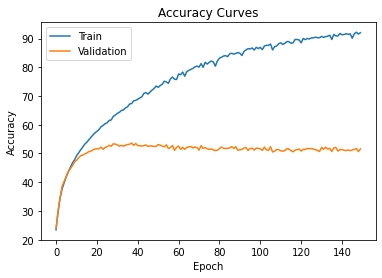

In [202]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_MLP,label='Train')
ax.plot(val_acc_MLP, label='Validation')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

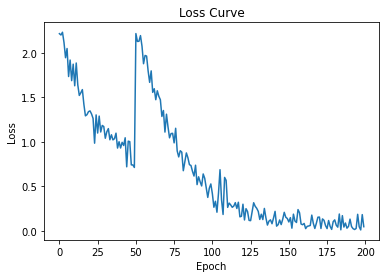

In [204]:
plt.plot(loss_epoch_arr_MLP)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Apply PCA (90 % Variance )and then Predict Using MLP

In [205]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [206]:
pca = PCA(0.9)
pca_result = pca.fit(x_train)

In [207]:
pca.n_components_

99

In [208]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [209]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [210]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [211]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [212]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=99, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [213]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [214]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [215]:
# Training Loop

loss_epoch_arr_PCA_90_MLP = []
max_epochs = 150
train_acc_PCA_90_MLP = []
val_acc_PCA_90_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_90_MLP.append(loss.item())
    train_acc_PCA_90_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_90_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.30
Iteration: 500/782, Loss: 2.06
Epoch: 1/150, Test acc: 30.91, Train acc: 30.68
Iteration: 0/782, Loss: 2.01
Iteration: 500/782, Loss: 1.92
Epoch: 2/150, Test acc: 36.09, Train acc: 36.15
Iteration: 0/782, Loss: 1.87
Iteration: 500/782, Loss: 1.87
Epoch: 3/150, Test acc: 38.85, Train acc: 38.43
Iteration: 0/782, Loss: 1.71
Iteration: 500/782, Loss: 1.75
Epoch: 4/150, Test acc: 40.70, Train acc: 40.60
Iteration: 0/782, Loss: 1.74
Iteration: 500/782, Loss: 1.76
Epoch: 5/150, Test acc: 42.33, Train acc: 42.04
Iteration: 0/782, Loss: 1.62
Iteration: 500/782, Loss: 1.73
Epoch: 6/150, Test acc: 42.92, Train acc: 43.51
Iteration: 0/782, Loss: 1.63
Iteration: 500/782, Loss: 1.64
Epoch: 7/150, Test acc: 44.21, Train acc: 44.09
Iteration: 0/782, Loss: 1.62
Iteration: 500/782, Loss: 1.68
Epoch: 8/150, Test acc: 45.05, Train acc: 45.42
Iteration: 0/782, Loss: 1.51
Iteration: 500/782, Loss: 1.61
Epoch: 9/150, Test acc: 45.50, Train acc: 46.28
Iteration: 0/782, Loss: 1.53

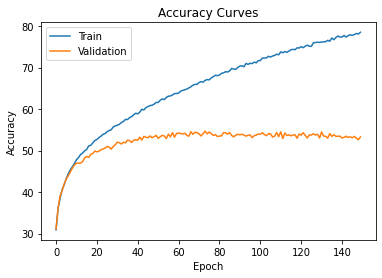

In [216]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_90_MLP,label='Train')
ax.plot(val_acc_PCA_90_MLP, label='Validation')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

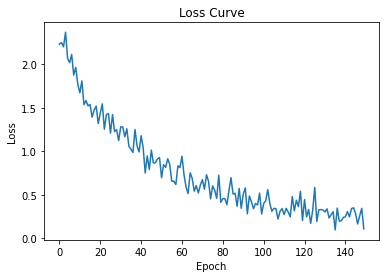

In [217]:
plt.plot(loss_epoch_arr_PCA_90_MLP)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Apply PCA (95 % Variance )and then Predict Using MLP

In [218]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [219]:
pca = PCA(0.95)
pca_result = pca.fit(x_train)

In [220]:
pca.n_components_

217

In [221]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [222]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [223]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [224]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [225]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=217, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [226]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [227]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [228]:
# Training Loop

loss_epoch_arr_PCA_95_MLP = []
max_epochs = 150
train_acc_PCA_95_MLP = []
val_acc_PCA_95_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_95_MLP.append(loss.item())
    train_acc_PCA_95_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_95_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 2.14
Epoch: 1/150, Test acc: 29.06, Train acc: 28.63
Iteration: 0/782, Loss: 2.08
Iteration: 500/782, Loss: 1.98
Epoch: 2/150, Test acc: 34.62, Train acc: 34.57
Iteration: 0/782, Loss: 1.88
Iteration: 500/782, Loss: 1.87
Epoch: 3/150, Test acc: 38.17, Train acc: 37.64
Iteration: 0/782, Loss: 1.76
Iteration: 500/782, Loss: 1.79
Epoch: 4/150, Test acc: 39.85, Train acc: 39.94
Iteration: 0/782, Loss: 1.71
Iteration: 500/782, Loss: 1.79
Epoch: 5/150, Test acc: 41.97, Train acc: 41.69
Iteration: 0/782, Loss: 1.64
Iteration: 500/782, Loss: 1.75
Epoch: 6/150, Test acc: 42.92, Train acc: 43.38
Iteration: 0/782, Loss: 1.62
Iteration: 500/782, Loss: 1.75
Epoch: 7/150, Test acc: 44.50, Train acc: 44.47
Iteration: 0/782, Loss: 1.57
Iteration: 500/782, Loss: 1.67
Epoch: 8/150, Test acc: 44.88, Train acc: 45.70
Iteration: 0/782, Loss: 1.49
Iteration: 500/782, Loss: 1.59
Epoch: 9/150, Test acc: 45.73, Train acc: 46.76
Iteration: 0/782, Loss: 1.56

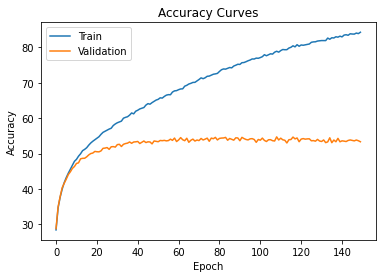

In [229]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_95_MLP,label='Train')
ax.plot(val_acc_PCA_95_MLP, label='Validation')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

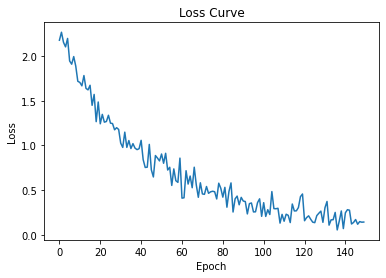

In [230]:
plt.plot(loss_epoch_arr_PCA_95_MLP)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Apply PCA (99 % Variance )and then Predict Using MLP

In [231]:
import tensorflow as tf
from sklearn.decomposition import PCA
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [232]:
pca = PCA(0.99)
pca_result = pca.fit(x_train)

In [233]:
pca.n_components_

658

In [234]:
PCA_train = pca.transform(x_train)
PCA_test = pca.transform(x_test)

In [235]:
PCA_train = torch.FloatTensor(PCA_train)
PCA_test = torch.FloatTensor(PCA_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [236]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(PCA_train,y_train) # create your datset
test_dataset = TensorDataset(PCA_test,y_test) # create your datset
trainloader = DataLoader(train_dataset,batch_size= 64) # create your dataloader
testloader = DataLoader(test_dataset,batch_size= 64) # create your dataloader

In [237]:
class ANN(nn.Module):
  def __init__(self):
      super().__init__()
      self.fc_model = nn.Sequential(
          nn.Linear(pca.n_components_,512),         # (N, 3072*2) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,512),             # (N, 512) -> (N, 512)
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(512,256),          # (N, 512) -> (N, 256)
          nn.Linear(256,10)            # (N, 256)  -> (N, 10)
      )
      
  def forward(self, x):
      x = self.fc_model(x)
      return x

In [238]:
net = ANN().to(device)
net

ANN(
  (fc_model): Sequential(
    (0): Linear(in_features=658, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [239]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(net.parameters(), lr=0.01)

In [240]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    # print("pred",pred )
    # print("labels",labels.squeeze(1))
    correct += (pred == labels.squeeze(1)).sum().item()
  return 100 * correct / total


In [241]:
# Training Loop

loss_epoch_arr_PCA_99_MLP = []
max_epochs = 150
train_acc_PCA_99_MLP = []
val_acc_PCA_99_MLP = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs, labels.squeeze(1))
        loss.backward()
        opt.step()

        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr_PCA_99_MLP.append(loss.item())
    train_acc_PCA_99_MLP.append(evaluation(trainloader, net))
    val_acc_PCA_99_MLP.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 2.20
Epoch: 1/150, Test acc: 26.31, Train acc: 25.44
Iteration: 0/782, Loss: 2.13
Iteration: 500/782, Loss: 2.04
Epoch: 2/150, Test acc: 31.10, Train acc: 30.85
Iteration: 0/782, Loss: 2.01
Iteration: 500/782, Loss: 1.94
Epoch: 3/150, Test acc: 35.51, Train acc: 35.67
Iteration: 0/782, Loss: 1.88
Iteration: 500/782, Loss: 1.82
Epoch: 4/150, Test acc: 38.69, Train acc: 38.51
Iteration: 0/782, Loss: 1.70
Iteration: 500/782, Loss: 1.79
Epoch: 5/150, Test acc: 40.62, Train acc: 40.83
Iteration: 0/782, Loss: 1.63
Iteration: 500/782, Loss: 1.70
Epoch: 6/150, Test acc: 42.83, Train acc: 42.66
Iteration: 0/782, Loss: 1.63
Iteration: 500/782, Loss: 1.74
Epoch: 7/150, Test acc: 43.89, Train acc: 44.33
Iteration: 0/782, Loss: 1.61
Iteration: 500/782, Loss: 1.71
Epoch: 8/150, Test acc: 44.94, Train acc: 45.66
Iteration: 0/782, Loss: 1.55
Iteration: 500/782, Loss: 1.60
Epoch: 9/150, Test acc: 46.29, Train acc: 47.04
Iteration: 0/782, Loss: 1.52

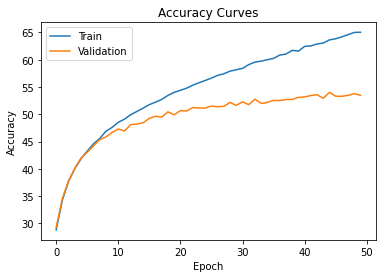

In [242]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc_PCA_99_MLP,label='Train')
ax.plot(val_acc_PCA_99_MLP, label='Validation')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

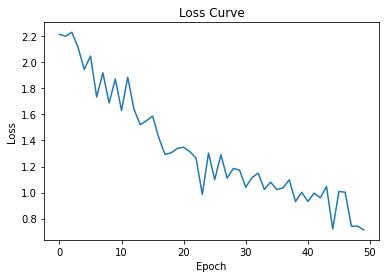

In [ ]:
plt.plot(loss_epoch_arr_PCA_99_MLP)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Train Accuracy PLot

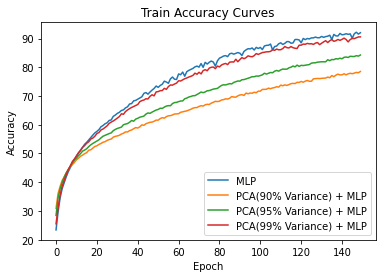

In [243]:
fig, ax = plt.subplots()

ax.plot(train_acc_MLP,label='MLP')
#ax.plot(train_acc_CNN_MLP,label='CNN + MLP')
ax.plot(train_acc_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(train_acc_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(train_acc_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Train Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Test Accuracy Plot

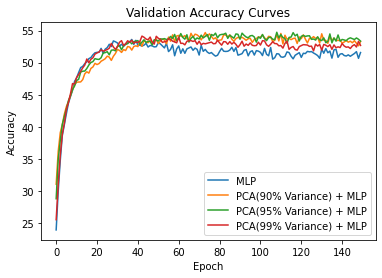

In [246]:
fig, ax = plt.subplots()

ax.plot(val_acc_MLP,label='MLP')
#ax.plot(val_acc_CNN_MLP,label='CNN + MLP')
ax.plot(val_acc_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(val_acc_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(val_acc_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Validation Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

## Loss Curves

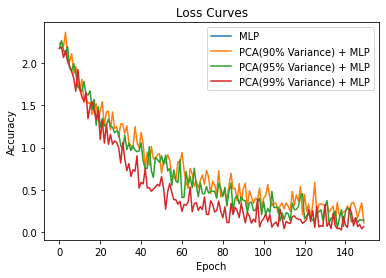

In [249]:
fig, ax = plt.subplots()

ax.plot(loss_epoch_arr_MLP,label='MLP')
#ax.plot(loss_epoch_arr_CNN_MLP,label='CNN + MLP')
ax.plot(loss_epoch_arr_PCA_90_MLP, label='PCA(90% Variance) + MLP')
ax.plot(loss_epoch_arr_PCA_95_MLP,label='PCA(95% Variance) + MLP')
ax.plot(loss_epoch_arr_PCA_99_MLP, label='PCA(99% Variance) + MLP')

plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")